<a href="https://colab.research.google.com/github/Gustavo-dev04/Analise-de-dados-de-acoes-com-ia/blob/main/Processamento_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== PREVISÃO RESILIENTE DE NVDA ===

📊 Baixando dados históricos...
✅ Dados baixados - 1257 dias | Último preço: $94.13

🧠 Preparando dados...
⚠️ Poucas notícias das fontes prioritárias, tentando secundárias...

📰 Análise de Sentimento:
➖ [NEUTRO] Nvidia And SMCI Are Cheaper Than Ever — But Wait For This Be... (Google News)
📈 [POSITIVO] Stocks making the biggest moves midday: Lululemon, Nike, Tes... (Google News)
➖ [NEUTRO] Analyst Explains Why Investors Keep Selling NVIDIA (NVDA) Sh... (Google News)
➖ [NEUTRO] Technology stocks fall for a second session after Trump tari... (Google News)
➖ [NEUTRO] Nvidia's (NVDA) Secret Investment Portfolio Is 100% Invested... (Google News)

🔍 Sentimento Médio: 0.01
✅ Dados preparados - 988 treino, 248 teste

🔮 Treinando modelo...
Época 0: MSE = 980.2696
Época 100: MSE = 2.3983
Época 200: MSE = 1.2219
✅ Convergência alcançada na época 201
✅ Treino concluído em 0.5s (MSE final: 1.2219)

📊 Avaliando modelo...


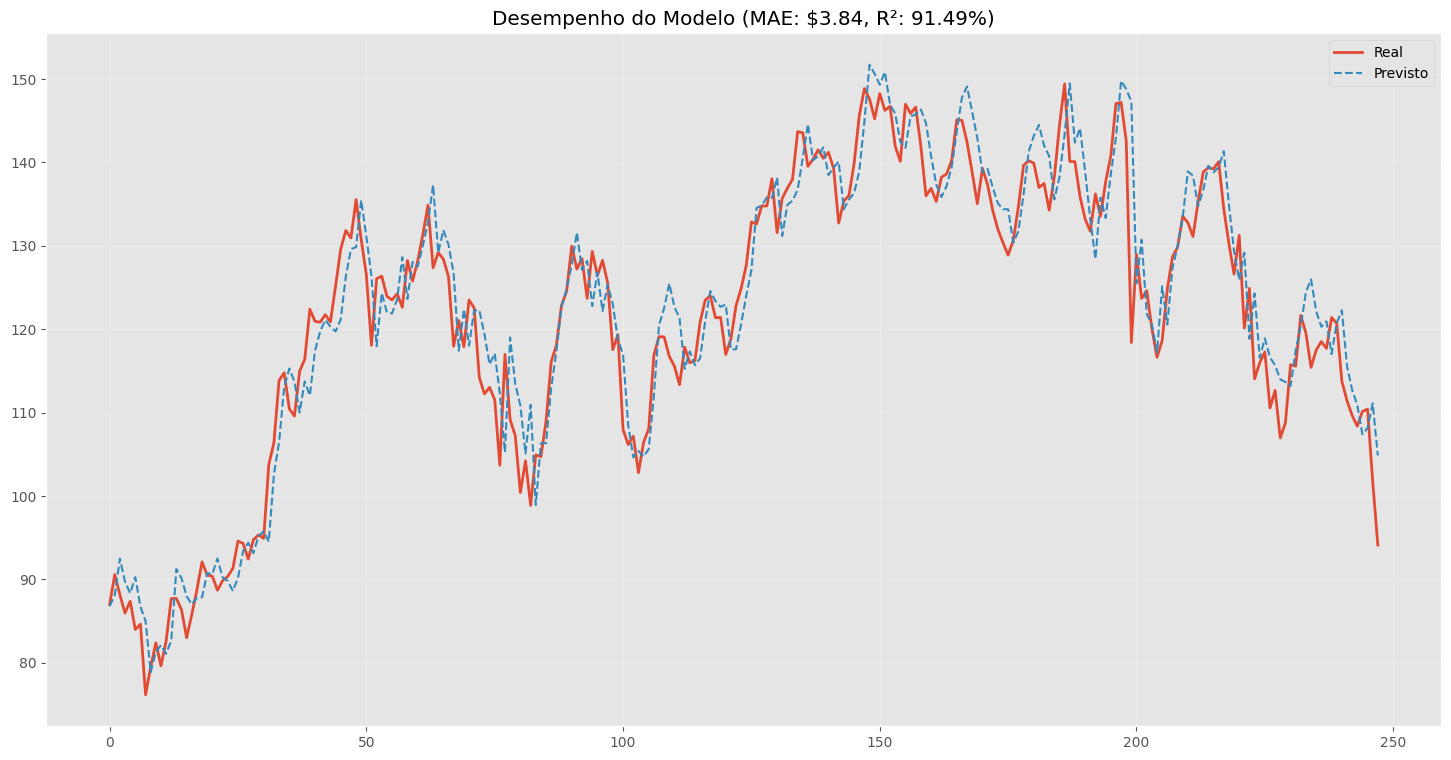


🔍 Resultados:
- MAE: $3.84
- RMSE: $5.01
- R²: 91.49%

🔮 Gerando previsões...


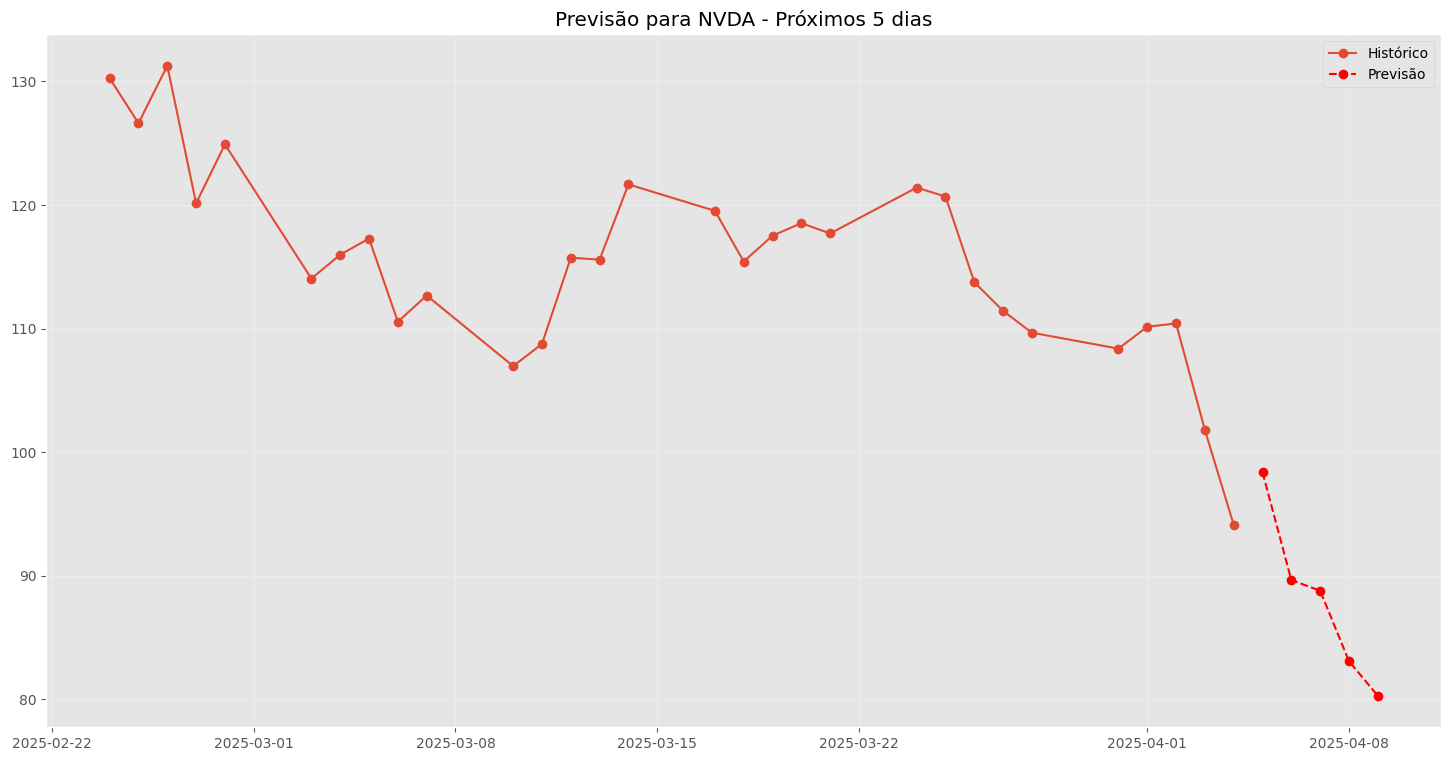


📈 Previsões para os próximos dias:
            forecast
date                
2025-04-05     98.37
2025-04-06     89.65
2025-04-07     88.80
2025-04-08     83.09
2025-04-09     80.29

⏱️ Tempo total: 4.6 segundos


In [22]:
# Importações essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests
from bs4 import BeautifulSoup
import feedparser
import time
import warnings
import re
from textblob import TextBlob
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 9)

# Parâmetros ajustáveis
SYMBOL = 'NVDA'
DAYS_TO_FETCH = 365 * 5  # 2 anos de dados
TEST_SIZE = 0.2
LEARNING_RATE = 0.05
EPOCHS = 100000
VOLATILITY_WINDOW = 20
REQUEST_TIMEOUT = 15
MIN_NEWS_ARTICLES = 3  # Mínimo de notícias necessárias
MAX_NEWS_ARTICLES = 15
SENTIMENT_IMPACT_FACTOR = 0.3

## --------------------------------------------------
## 1. SISTEMA ROBUSTO DE COLETA DE NOTÍCIAS
## --------------------------------------------------

class ResilientNewsCollector:
    def __init__(self):
        self.session = requests.Session()
        self.session.timeout = REQUEST_TIMEOUT

        # Configuração de headers para evitar bloqueios
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9'
        }

        # Fontes prioritárias e secundárias
        self.priority_sources = [
            {'name': 'Yahoo Finance', 'url': f'https://finance.yahoo.com/quote/{SYMBOL}/news', 'scraper': self._scrape_yahoo},
            {'name': 'MarketWatch', 'url': f'https://www.marketwatch.com/investing/stock/{SYMBOL}/news', 'scraper': self._scrape_marketwatch},
            {'name': 'Seeking Alpha', 'url': f'https://seekingalpha.com/symbol/{SYMBOL}/news', 'scraper': self._scrape_seeking_alpha}
        ]

        self.secondary_sources = [
            {'name': 'Investing.com', 'url': f'https://www.investing.com/equities/nvidia-corp-news', 'scraper': self._scrape_investing},
            {'name': 'Google News RSS', 'url': f'https://news.google.com/rss/search?q={SYMBOL}+stock&hl=en-US&gl=US&ceid=US:en', 'scraper': self._scrape_google_rss}
        ]

        # Dicionário de termos financeiros
        self.finance_lexicon = {
            'positive': ['beat', 'raise', 'upgrade', 'strong', 'growth', 'bullish', 'outperform', 'surge', 'rally'],
            'negative': ['cut', 'lower', 'downgrade', 'weak', 'bearish', 'underperform', 'drop', 'plunge', 'slump']
        }

    def _scrape_yahoo(self, url):
        """Scraping resiliente do Yahoo Finance"""
        articles = []
        try:
            response = self.session.get(url, headers=self.headers, timeout=REQUEST_TIMEOUT)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Tenta dois seletores diferentes
            selectors = ['h3[data-test-locator="headline"]', 'li.js-stream-content h3']

            for selector in selectors:
                if not articles:  # Só continua se não encontrou nada no primeiro seletor
                    for item in soup.select(selector)[:5]:
                        title = item.get_text(strip=True)
                        link = item.find_parent('a')['href'] if item.find_parent('a') else ''
                        articles.append({
                            'title': title,
                            'url': f'https://finance.yahoo.com{link}' if link.startswith('/') else link,
                            'source': 'Yahoo Finance'
                        })
        except Exception as e:
            print(f"⚠️ Erro no Yahoo Finance: {str(e)}")
        return articles[:5]

    def _scrape_marketwatch(self, url):
        """Scraping resiliente do MarketWatch"""
        articles = []
        try:
            response = self.session.get(url, headers=self.headers, timeout=REQUEST_TIMEOUT)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Tenta dois seletores diferentes
            selectors = ['div.article__content', 'div.article__details']

            for selector in selectors:
                if len(articles) < 3:  # Continua se não encontrou o suficiente
                    for item in soup.select(selector)[:5]:
                        title = item.select_one('h3 a')
                        if title:
                            title_text = title.get_text(strip=True)
                            content = ' '.join([p.get_text(strip=True) for p in item.select('p')])
                            articles.append({
                                'title': title_text,
                                'content': content,
                                'source': 'MarketWatch'
                            })
        except Exception as e:
            print(f"⚠️ Erro no MarketWatch: {str(e)}")
        return articles[:5]

    def _scrape_seeking_alpha(self, url):
        """Scraping resiliente do Seeking Alpha"""
        articles = []
        try:
            response = self.session.get(url, headers=self.headers, timeout=REQUEST_TIMEOUT)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Tenta dois seletores diferentes
            selectors = ['div.content-block-inner li', 'div.symbol_article']

            for selector in selectors:
                if len(articles) < 3:
                    for item in soup.select(selector)[:5]:
                        title = item.select_one('a')
                        if title:
                            articles.append({
                                'title': title.get_text(strip=True),
                                'url': title['href'],
                                'source': 'Seeking Alpha'
                            })
        except Exception as e:
            print(f"⚠️ Erro no Seeking Alpha: {str(e)}")
        return articles[:5]

    def _scrape_investing(self, url):
        """Scraping resiliente do Investing.com"""
        articles = []
        try:
            response = self.session.get(url, headers=self.headers, timeout=REQUEST_TIMEOUT)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Tenta múltiplos seletores
            selectors = ['div.mediumTitle1 article.articleItem', 'div.largeTitle article.articleItem']

            for selector in selectors:
                if len(articles) < 3:
                    for item in soup.select(selector)[:5]:
                        title = item.select_one('a.title')
                        if title:
                            articles.append({
                                'title': title.get_text(strip=True),
                                'url': 'https://www.investing.com' + title['href'],
                                'source': 'Investing.com'
                            })
        except Exception as e:
            print(f"⚠️ Erro no Investing.com: {str(e)}")
        return articles[:5]

    def _scrape_google_rss(self, url):
        """Scraping resiliente do Google News RSS"""
        articles = []
        try:
            # Tenta parsear o feed com timeout via requests
            response = self.session.get(url, timeout=REQUEST_TIMEOUT)
            feed = feedparser.parse(response.text)

            for entry in feed.entries[:5]:
                articles.append({
                    'title': entry.title,
                    'url': entry.link,
                    'source': 'Google News'
                })
        except Exception as e:
            print(f"⚠️ Erro no Google News RSS: {str(e)}")
        return articles

    def _get_synthetic_news(self):
        """Gera notícias sintéticas baseadas no desempenho recente"""
        synthetic = []
        patterns = [
            f"{SYMBOL} shows {np.random.choice(['strong', 'steady', 'impressive'])} performance",
            f"Analysts {np.random.choice(['raise', 'maintain', 'lower'])} outlook for {SYMBOL}",
            f"{SYMBOL} {np.random.choice(['gains', 'holds', 'dips'])} amid market {np.random.choice(['rally', 'volatility', 'calm'])}"
        ]

        for _ in range(MIN_NEWS_ARTICLES):
            synthetic.append({
                'title': np.random.choice(patterns),
                'source': 'Synthetic News'
            })

        return synthetic

    def fetch_news(self):
        """Coleta notícias com resiliência"""
        articles = []

        # Primeiro tenta fontes prioritárias
        with ThreadPoolExecutor(max_workers=len(self.priority_sources)) as executor:
            futures = [executor.submit(source['scraper'], source['url']) for source in self.priority_sources]

            for future in as_completed(futures):
                try:
                    articles.extend(future.result())
                except Exception as e:
                    print(f"⚠️ Erro na coleta prioritária: {str(e)}")

        # Se não obteve o mínimo, tenta fontes secundárias
        if len(articles) < MIN_NEWS_ARTICLES:
            print("⚠️ Poucas notícias das fontes prioritárias, tentando secundárias...")
            with ThreadPoolExecutor(max_workers=len(self.secondary_sources)) as executor:
                futures = [executor.submit(source['scraper'], source['url']) for source in self.secondary_sources]

                for future in as_completed(futures):
                    try:
                        articles.extend(future.result())
                    except Exception as e:
                        print(f"⚠️ Erro na coleta secundária: {str(e)}")

        # Se ainda não tem o mínimo, gera notícias sintéticas
        if len(articles) < MIN_NEWS_ARTICLES:
            print("⚠️ Usando notícias sintéticas para complementar análise...")
            articles.extend(self._get_synthetic_news())

        # Processamento final
        return self._process_articles(articles[:MAX_NEWS_ARTICLES])

    def _process_articles(self, articles):
        """Processa e filtra artigos"""
        # Remove duplicatas
        unique = []
        seen = set()

        for article in articles:
            title = article['title']
            norm_title = re.sub(r'\W+', '', title.lower())
            if norm_title not in seen:
                seen.add(norm_title)
                unique.append(article)

        return unique

    def analyze_sentiment(self, articles):
        """Análise de sentimento resiliente"""
        if not articles:
            print("⚠️ Nenhuma notícia disponível para análise, usando sentimento neutro")
            return {'sentiment': 0, 'recent_impact': 0, 'trend': 0}

        sentiment_scores = []
        print("\n📰 Análise de Sentimento:")

        for article in articles:
            text = article['title']
            if 'content' in article:
                text += ' ' + article['content']

            # Análise com TextBlob
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity

            # Análise de palavras-chave
            keyword_score = 0
            text_lower = text.lower()
            for word in self.finance_lexicon['positive']:
                if word in text_lower:
                    keyword_score += 0.2
            for word in self.finance_lexicon['negative']:
                if word in text_lower:
                    keyword_score -= 0.3

            # Combina os scores
            combined_score = (polarity + keyword_score) / 2
            sentiment_scores.append(combined_score)

            # Classificação
            if combined_score > 0.2:
                emoji = "📈"
                sentiment = "POSITIVO"
            elif combined_score < -0.2:
                emoji = "📉"
                sentiment = "NEGATIVO"
            else:
                emoji = "➖"
                sentiment = "NEUTRO"

            print(f"{emoji} [{sentiment}] {article['title'][:60]}... ({article['source']})")

        avg_sentiment = np.mean(sentiment_scores) if sentiment_scores else 0
        print(f"\n🔍 Sentimento Médio: {avg_sentiment:.2f}")

        return {
            'sentiment': avg_sentiment,
            'recent_impact': avg_sentiment * 1.2,
            'trend': 0  # Simplificado para esta versão
        }

## --------------------------------------------------
## 2. MODELO DE PREVISÃO RESILIENTE
## --------------------------------------------------

class ResilientStockPredictor:
    def __init__(self):
        self.learning_rate = LEARNING_RATE
        self.epochs = EPOCHS
        self.weights = None
        self.bias = None
        self.scaler = None
        self.news_analyzer = ResilientNewsCollector()
        self.base_features = ['close', 'volume', 'ma_5', 'ma_20', 'volatility', 'momentum']
        self.news_features = ['news_sentiment']
        self.feature_cols = self.base_features.copy()

    def prepare_data(self, df):
        """Preparação resiliente dos dados"""
        try:
            # Feature Engineering básico
            df['returns'] = df['close'].pct_change()
            df['ma_5'] = df['close'].rolling(5).mean()
            df['ma_20'] = df['close'].rolling(20).mean()
            df['volatility'] = df['returns'].rolling(VOLATILITY_WINDOW).std()
            df['momentum'] = df['close'] - df['close'].shift(5)

            # Adiciona sentimento de notícias
            news_impact = self.news_analyzer.analyze_sentiment(self.news_analyzer.fetch_news())
            df['news_sentiment'] = news_impact['sentiment']
            self.feature_cols.append('news_sentiment')

            # Remove NA
            df = df.dropna()

            # Verificação final das features
            available_features = [f for f in self.feature_cols if f in df.columns]
            if len(available_features) != len(self.feature_cols):
                print(f"⚠️ Ajustando features: esperado {len(self.feature_cols)}, disponível {len(available_features)}")
                self.feature_cols = available_features

            # Separa features e target
            X = df[self.feature_cols]
            y = df['close'].shift(-1).dropna()
            X = X.iloc[:-1]

            # Normalização
            self.scaler = RobustScaler()
            X_scaled = self.scaler.fit_transform(X)

            # Divisão treino-teste
            split_idx = int(len(X) * (1 - TEST_SIZE))
            X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]

            return X_train, X_test, y_train, y_test, df

        except Exception as e:
            print(f"⚠️ Erro na preparação: {str(e)}")
            # Fallback para apenas features básicas
            self.feature_cols = self.base_features.copy()
            return self.prepare_data(df)

    def train(self, X, y):
        """Treinamento resiliente"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        best_error = float('inf')

        for epoch in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            error = np.mean((y_pred - y)**2)

            # Early stopping básico
            if epoch > 100 and error > best_error * 0.999:
                print(f"✅ Convergência alcançada na época {epoch}")
                break

            if error < best_error:
                best_error = error

            # Gradientes
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Atualização
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if epoch % 100 == 0:
                print(f"Época {epoch}: MSE = {error:.4f}")

        return best_error

    def predict(self, X):
        """Previsão com verificação de dimensões"""
        if X.shape[1] != len(self.feature_cols):
            raise ValueError(f"Dimensão incorreta. Esperado {len(self.feature_cols)} features, obtido {X.shape[1]}")

        return np.dot(X, self.weights) + self.bias

    def evaluate(self, X_test, y_test):
        """Avaliação resiliente"""
        try:
            y_pred = self.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            plt.figure(figsize=(18, 9))
            plt.plot(y_test.values, label='Real', linewidth=2)
            plt.plot(y_pred, label='Previsto', linestyle='--')
            plt.title(f'Desempenho do Modelo (MAE: ${mae:.2f}, R²: {r2:.2%})')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

            return {'mae': mae, 'rmse': rmse, 'r2': r2}

        except Exception as e:
            print(f"⚠️ Erro na avaliação: {str(e)}")
            return {'mae': None, 'rmse': None, 'r2': None}

    def forecast(self, df, days=5):
        """Previsão futura resiliente"""
        try:
            # Verifica features disponíveis
            available_features = [f for f in self.feature_cols if f in df.columns]
            if len(available_features) != len(self.feature_cols):
                print(f"⚠️ Ajustando features para previsão: esperado {len(self.feature_cols)}, disponível {len(available_features)}")
                self.feature_cols = available_features

            forecasts = []
            last_row = df.iloc[-1][self.feature_cols].values.reshape(1, -1)

            for _ in range(days):
                X_scaled = self.scaler.transform(last_row)
                pred = self.predict(X_scaled)[0]
                forecasts.append(pred)

                # Atualiza features
                new_row = last_row.copy()
                new_row[0][0] = pred  # Preço

                # Atualiza médias móveis se estiverem nas features
                if 'ma_5' in self.feature_cols:
                    ma5_idx = self.feature_cols.index('ma_5')
                    new_row[0][ma5_idx] = (new_row[0][0] + last_row[0][0] * 4) / 5

                if 'ma_20' in self.feature_cols:
                    ma20_idx = self.feature_cols.index('ma_20')
                    new_row[0][ma20_idx] = (new_row[0][0] + last_row[0][0] * 19) / 20

                last_row = new_row

            # Resultado
            dates = [df.index[-1] + timedelta(days=i+1) for i in range(days)]
            forecast_df = pd.DataFrame({'date': dates, 'forecast': forecasts})
            forecast_df.set_index('date', inplace=True)

            plt.figure(figsize=(18, 9))
            plt.plot(df['close'].iloc[-30:], label='Histórico', marker='o')
            plt.plot(forecast_df['forecast'], label='Previsão', color='red', linestyle='--', marker='o')
            plt.title(f'Previsão para {SYMBOL} - Próximos {days} dias')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

            return forecast_df

        except Exception as e:
            print(f"⚠️ Erro na previsão: {str(e)}")
            return None

## --------------------------------------------------
## 3. EXECUÇÃO PRINCIPAL RESILIENTE
## --------------------------------------------------

def main():
    print(f"\n{'='*50}")
    print(f"=== PREVISÃO RESILIENTE DE {SYMBOL} ===")
    print(f"{'='*50}\n")

    try:
        # 1. Baixa dados históricos
        print("📊 Baixando dados históricos...")
        start_time = time.time()
        df = yf.download(SYMBOL, period=f"{DAYS_TO_FETCH//365}y", progress=False)
        df = df[['Close', 'Volume']]
        df.columns = ['close', 'volume']
        print(f"✅ Dados baixados - {len(df)} dias | Último preço: ${df['close'].iloc[-1]:.2f}")

        # 2. Prepara dados
        print("\n🧠 Preparando dados...")
        predictor = ResilientStockPredictor()
        X_train, X_test, y_train, y_test, df_processed = predictor.prepare_data(df)
        print(f"✅ Dados preparados - {len(X_train)} treino, {len(X_test)} teste")

        # 3. Treina modelo
        print("\n🔮 Treinando modelo...")
        train_start = time.time()
        final_error = predictor.train(X_train, y_train)
        print(f"✅ Treino concluído em {time.time()-train_start:.1f}s (MSE final: {final_error:.4f})")

        # 4. Avaliação
        print("\n📊 Avaliando modelo...")
        metrics = predictor.evaluate(X_test, y_test)
        if metrics['mae'] is not None:
            print(f"\n🔍 Resultados:")
            print(f"- MAE: ${metrics['mae']:.2f}")
            print(f"- RMSE: ${metrics['rmse']:.2f}")
            print(f"- R²: {metrics['r2']:.2%}")

        # 5. Previsão
        print("\n🔮 Gerando previsões...")
        forecast = predictor.forecast(df_processed)
        if forecast is not None:
            print("\n📈 Previsões para os próximos dias:")
            print(forecast.round(2))

    except KeyboardInterrupt:
        print("\n⏹️ Execução interrompida pelo usuário")
    except Exception as e:
        print(f"\n❌ Erro: {str(e)}")
    finally:
        print(f"\n⏱️ Tempo total: {time.time()-start_time:.1f} segundos")

if __name__ == "__main__":
    # Verificação de dependências
    try:
        import yfinance
        from textblob import TextBlob
    except ImportError:
        print("Instalando dependências...")
        import subprocess
        subprocess.run(['pip', 'install', 'yfinance', 'scikit-learn', 'beautifulsoup4', 'feedparser', 'textblob'])
        import nltk
        nltk.download('punkt')

    main()